In [101]:
import torch
import math
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from synthetic_functions.syngp import SynGP
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths

from tueplots import bundles
plt.rcParams.update(bundles.iclr2024())

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

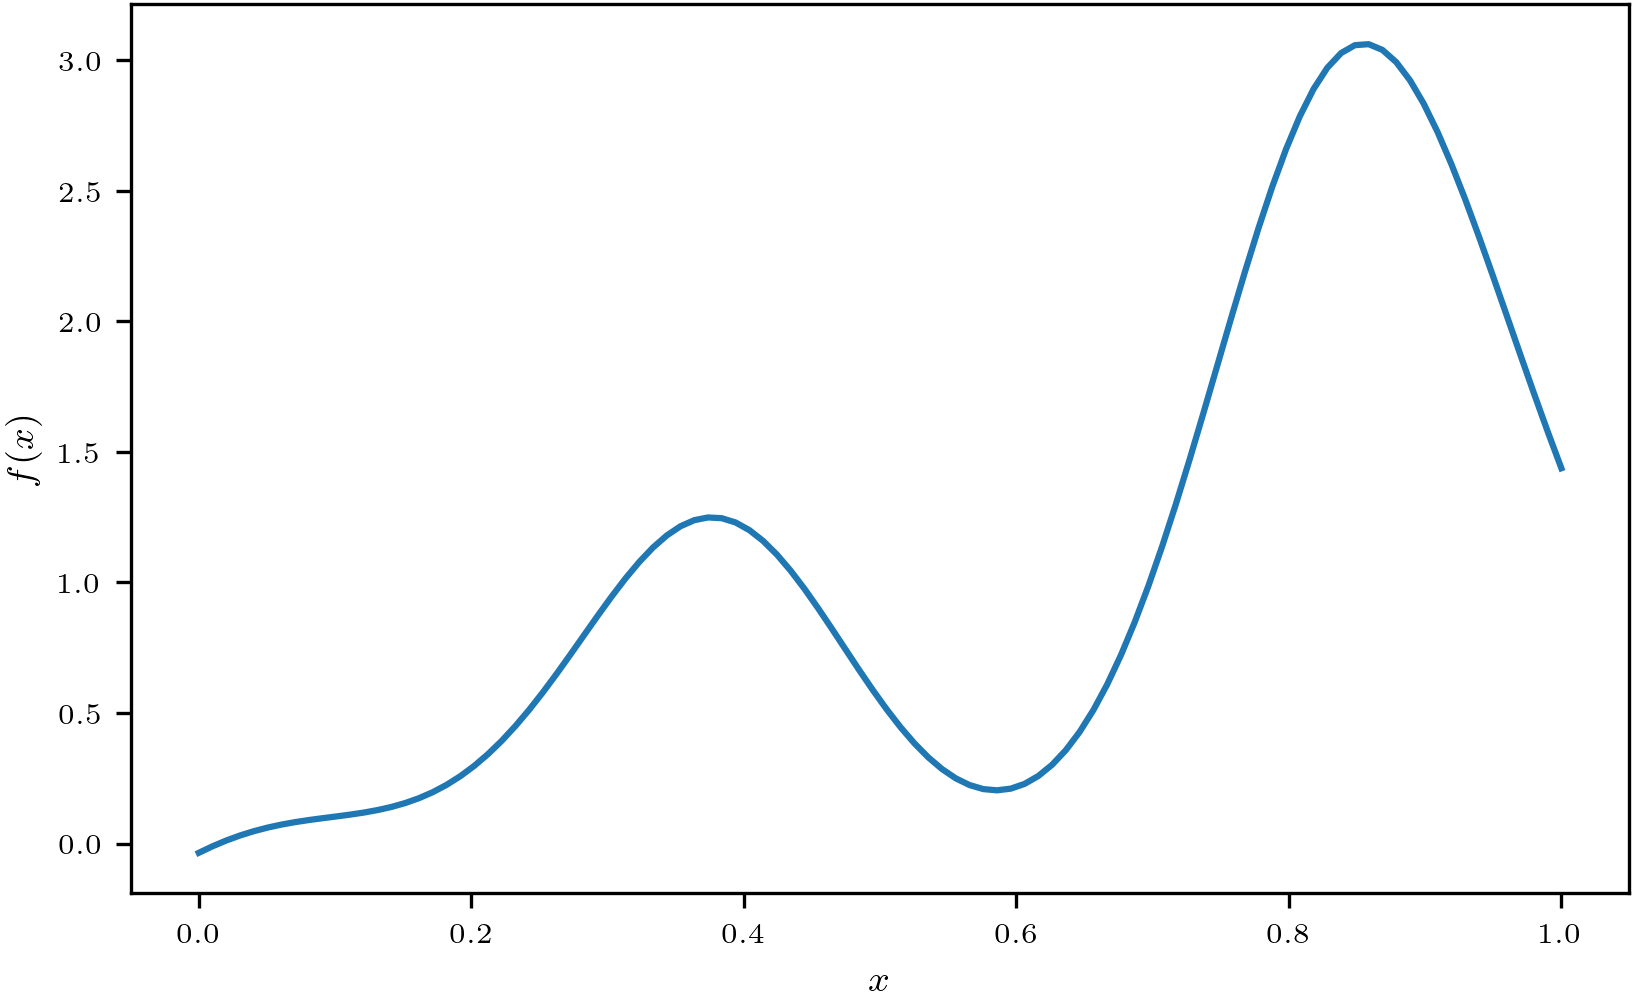

In [7]:
# def function(x):
#     return torch.sin(2 * x) + (10 / (1 + (x + 9)**2)) - (2 / (1 + (x + 3)**2))
hidden_function = SynGP(dim=1, seed=6)
hidden_function.hypers = {"ls": 0.1, "alpha": 1.0, "sigma": 1e-2}

def function(x):
    return hidden_function(x-0.2)

# Create a range of x values
X = torch.tensor(np.linspace(0, 1, 100))
y = function(X.reshape(-1, 1))

# Plot the samples
plt.plot(X.numpy(), y.numpy())
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

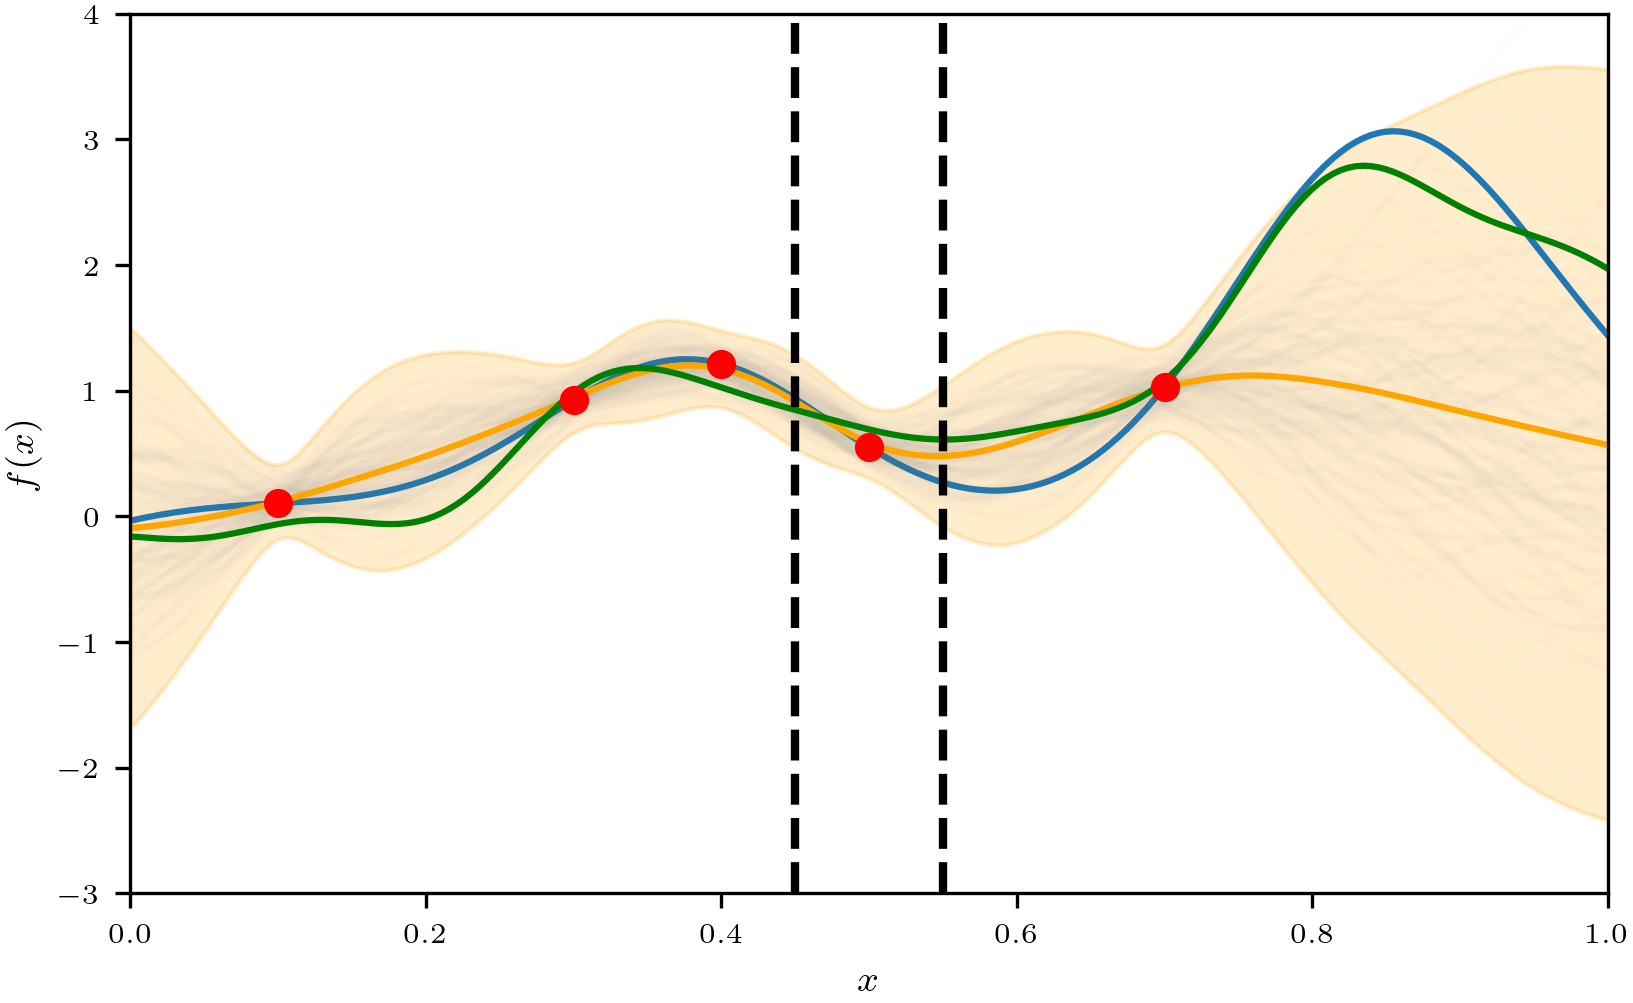

In [178]:
torch.manual_seed(45)

# Random 3 points in range(-3, 3)
points = torch.tensor([[0.1], [0.3], [0.4], [0.5], [0.7]]).double()
point_Ys = function(points)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.NormalPrior(0, 1e-2)
)

gp_model = SingleTaskGP(
    train_X=points,
    train_Y=point_Ys,
    likelihood=likelihood,
)
hparams = {"ls": 0.2, "alpha": 1.0, "sigma": 1e-2}
gp_model.covar_module.base_kernel.lengthscale = hparams["ls"]
gp_model.covar_module.outputscale = hparams["alpha"]
gp_model.likelihood.noise = hparams["sigma"]
gp_model.eval()

# mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
# fit_gpytorch_mll(mll)

# Create a range of x values
X = torch.tensor(np.linspace(0, 1, 200)).reshape(-1, 1)
y = function(X)

y_post = gp_model(X.float()).sample(torch.Size([128]))
y_mean = y_post.mean(0)
y_std = y_post.std(0)

radius = 0.05
mid_point = points[3][0]
lower_bound = mid_point - radius
upper_bound = mid_point + radius

f = draw_matheron_paths(gp_model, torch.Size([128]))
y_post_ts = f(X.float())[36].detach()

# Plot the samples
plt.plot(X.numpy(), y.numpy())
plt.plot(X.numpy(), y_post.numpy().T, alpha=0.01, color="gray")
plt.plot(X.numpy(), y_mean.numpy(), color="orange")

plt.fill_between(
    X.flatten().numpy(),
    y_mean.flatten().numpy() - 3 * y_std.flatten().numpy(),
    y_mean.flatten().numpy() + 3 * y_std.flatten().numpy(),
    color="orange",
    alpha=0.2,
)
plt.plot(X.numpy(), y_post_ts.numpy(), color="green")
plt.scatter(points.numpy(), point_Ys.numpy(), color='red', zorder=99)

# plt.axvline(x=mid_point, color='black', linestyle='--')
plt.axvline(x=lower_bound, color='black', linestyle='--', linewidth=2)
plt.axvline(x=upper_bound, color='black', linestyle='--', linewidth=2)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(-3, 4)

plt.savefig("step1.png")
plt.show()
plt.close()

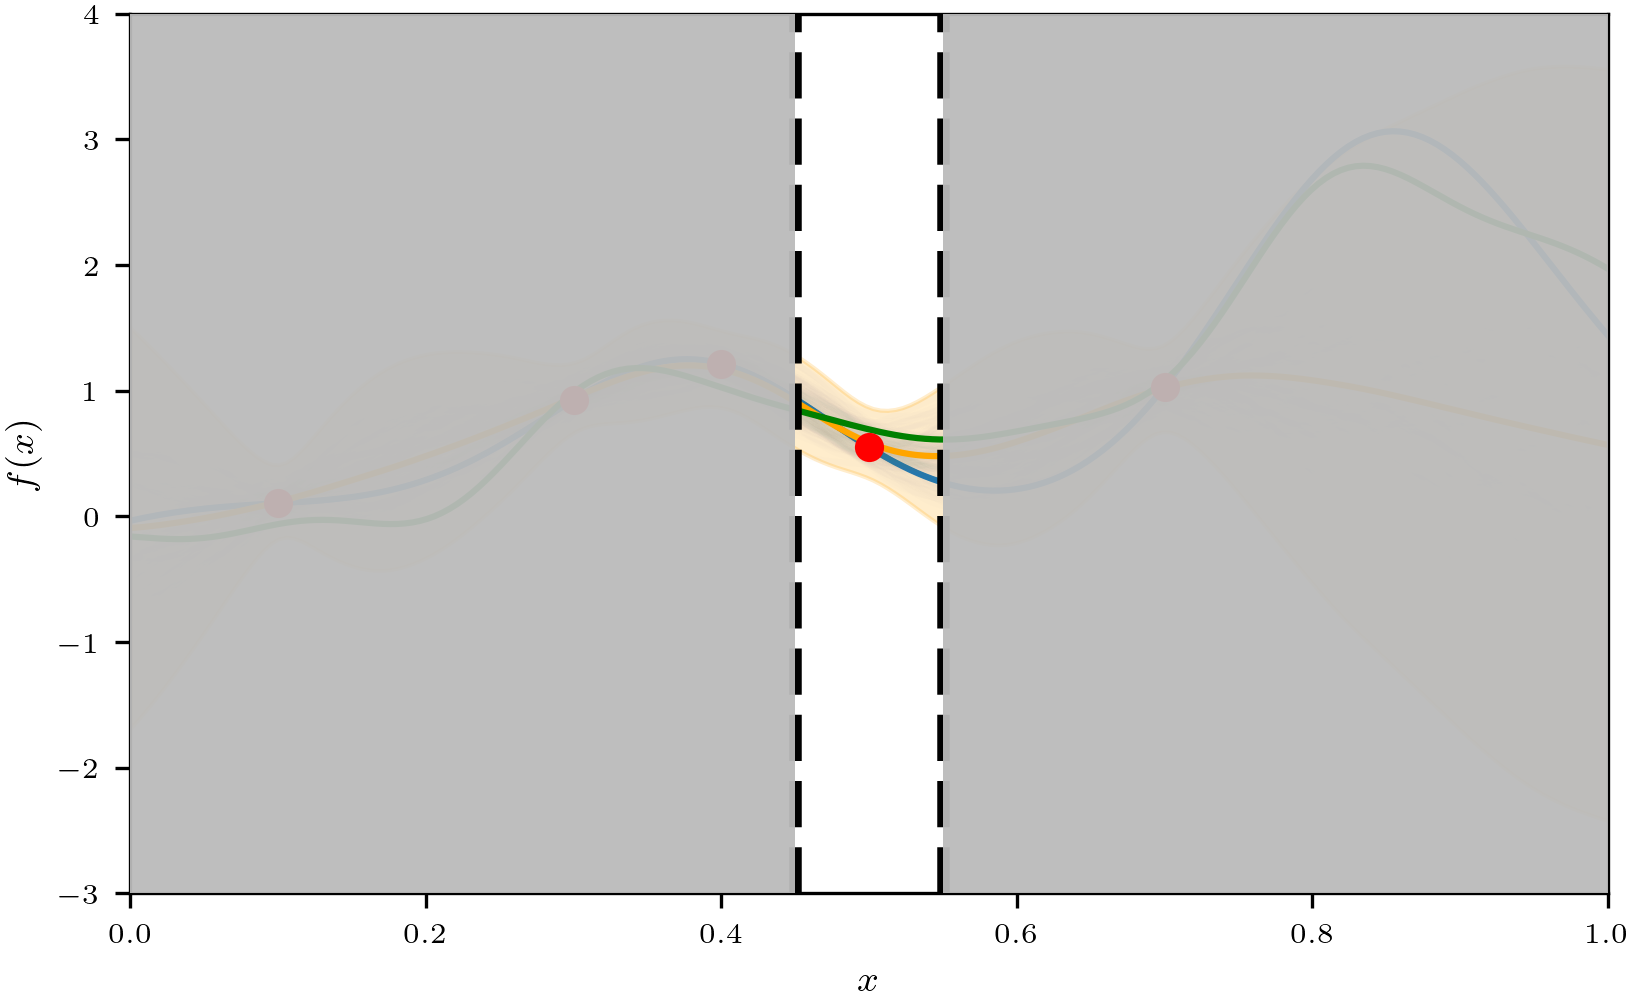

In [158]:
torch.manual_seed(45)

# Random 3 points in range(-3, 3)
points = torch.tensor([[0.1], [0.3], [0.4], [0.5], [0.7]]).double()
point_Ys = function(points)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.NormalPrior(0, 1e-2)
)

gp_model = SingleTaskGP(
    train_X=points,
    train_Y=point_Ys,
    likelihood=likelihood,
)
hparams = {"ls": 0.2, "alpha": 1.0, "sigma": 1e-2}
gp_model.covar_module.base_kernel.lengthscale = hparams["ls"]
gp_model.covar_module.outputscale = hparams["alpha"]
gp_model.likelihood.noise = hparams["sigma"]
gp_model.eval()

# mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
# fit_gpytorch_mll(mll)

# Create a range of x values
X = torch.tensor(np.linspace(0, 1, 200)).reshape(-1, 1)
y = function(X)

y_post = gp_model(X.float()).sample(torch.Size([128]))
y_mean = y_post.mean(0)
y_std = y_post.std(0)

radius = 0.05
mid_point = points[3][0]
lower_bound = mid_point - radius
upper_bound = mid_point + radius

f = draw_matheron_paths(gp_model, torch.Size([128]))
y_post_ts = f(X.float())[36].detach()

# Plot the samples
plt.plot(X.numpy(), y.numpy())
plt.plot(X.numpy(), y_post.numpy().T, alpha=0.01, color="gray")
plt.plot(X.numpy(), y_mean.numpy(), color="orange")
plt.fill_between(
    X.flatten().numpy(),
    y_mean.flatten().numpy() - 3 * y_std.flatten().numpy(),
    y_mean.flatten().numpy() + 3 * y_std.flatten().numpy(),
    color="orange",
    alpha=0.2,
)
plt.plot(X.numpy(), y_post_ts.numpy(), color="green")
plt.scatter(points.numpy(), point_Ys.numpy(), color='red', zorder=99)

# plt.axvline(x=mid_point, color='black', linestyle='--')
plt.axvline(x=lower_bound, color='black', linestyle='--', linewidth=3)
plt.axvline(x=upper_bound, color='black', linestyle='--', linewidth=3)

plt.axvspan(0, lower_bound, facecolor='#BBBBBB', alpha=0.95, zorder=99)
plt.axvspan(upper_bound, 1, facecolor='#BBBBBB', alpha=0.95, zorder=99)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(-3, 4)

plt.savefig("step2.png")
plt.show()
plt.close()

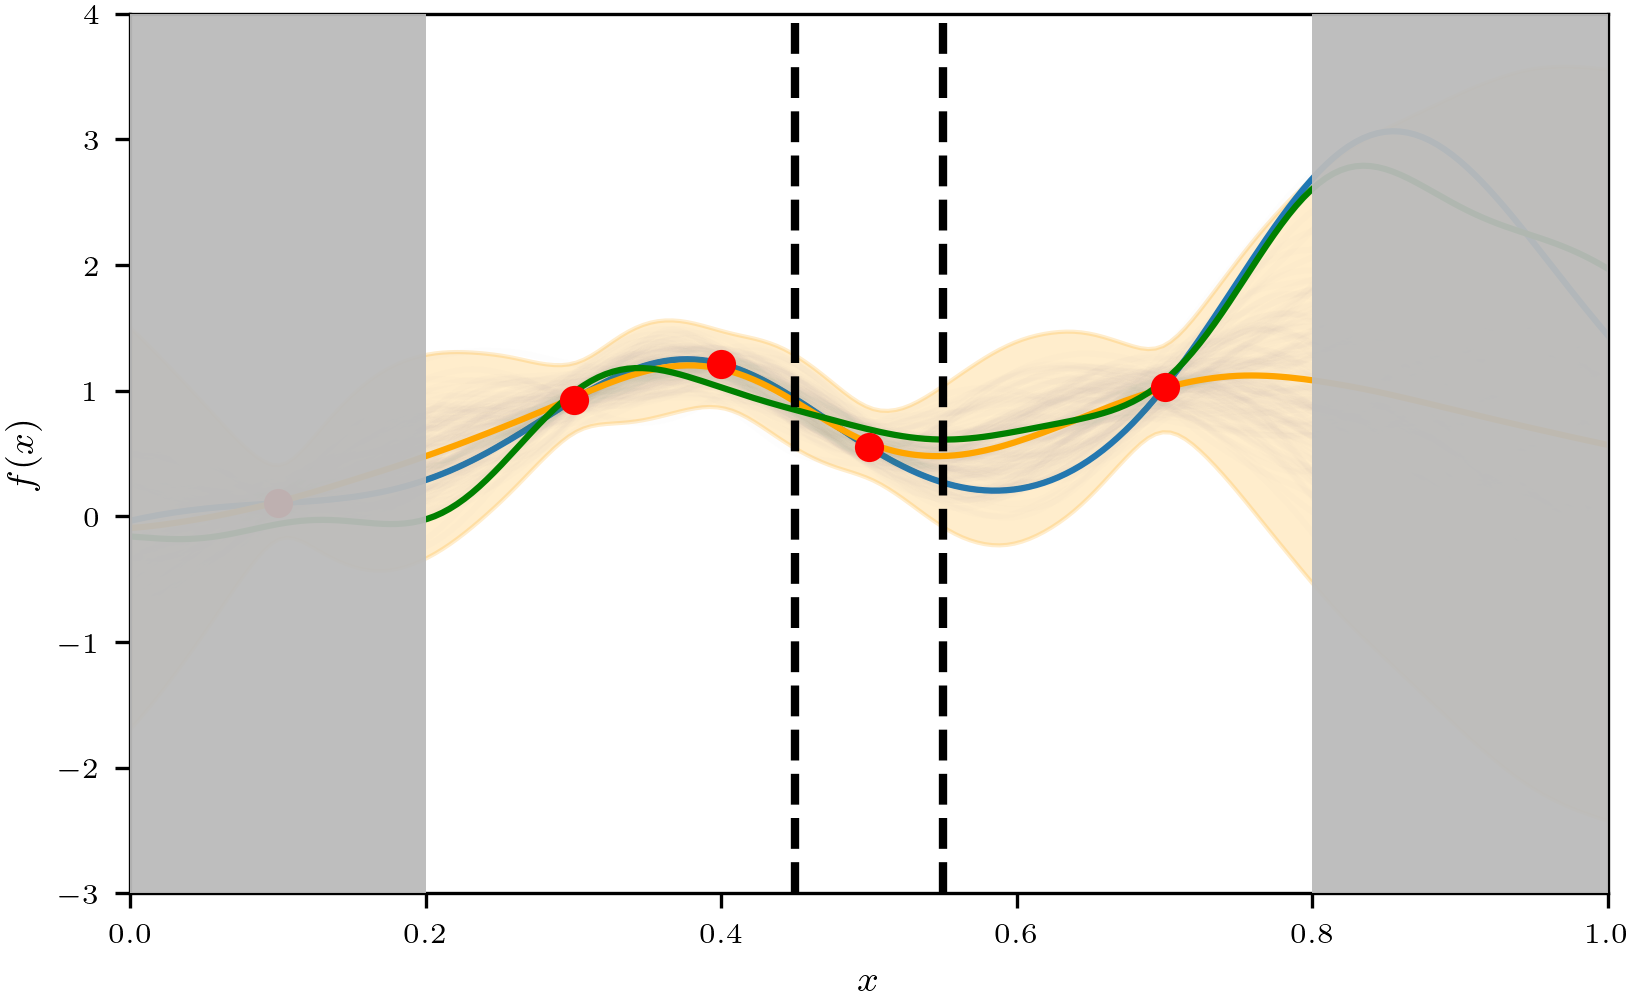

In [159]:
torch.manual_seed(45)

# Random 3 points in range(-3, 3)
points = torch.tensor([[0.1], [0.3], [0.4], [0.5], [0.7]]).double()
point_Ys = function(points)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.NormalPrior(0, 1e-2)
)

gp_model = SingleTaskGP(
    train_X=points,
    train_Y=point_Ys,
    likelihood=likelihood,
)
hparams = {"ls": 0.2, "alpha": 1.0, "sigma": 1e-2}
gp_model.covar_module.base_kernel.lengthscale = hparams["ls"]
gp_model.covar_module.outputscale = hparams["alpha"]
gp_model.likelihood.noise = hparams["sigma"]
gp_model.eval()

# Create a range of x values
X = torch.tensor(np.linspace(0, 1, 200)).reshape(-1, 1)
y = function(X)

y_post = gp_model(X.float()).sample(torch.Size([128]))
y_mean = y_post.mean(0)
y_std = y_post.std(0)

radius = 0.3
mid_point = points[3][0]
lower_bound = mid_point - radius
upper_bound = mid_point + radius

f = draw_matheron_paths(gp_model, torch.Size([128]))
y_post_ts = f(X.float())[36].detach()

# Plot the samples
plt.plot(X.numpy(), y.numpy())
plt.plot(X.numpy(), y_post.numpy().T, alpha=0.01, color="gray")
plt.plot(X.numpy(), y_mean.numpy(), color="orange")
plt.fill_between(
    X.flatten().numpy(),
    y_mean.flatten().numpy() - 3 * y_std.flatten().numpy(),
    y_mean.flatten().numpy() + 3 * y_std.flatten().numpy(),
    color="orange",
    alpha=0.2,
)
plt.plot(X.numpy(), y_post_ts.numpy(), color="green")
plt.scatter(points.numpy(), point_Ys.numpy(), color='red', zorder=99)

# plt.axvline(x=mid_point, color='black', linestyle='--')
plt.axvline(x=mid_point - 0.05, color='black', linestyle='--', linewidth=2)
plt.axvline(x=mid_point + 0.05, color='black', linestyle='--', linewidth=2)

plt.axvspan(0, lower_bound, facecolor='#BBBBBB', alpha=0.95, zorder=99)
plt.axvspan(upper_bound, 1, facecolor='#BBBBBB', alpha=0.95, zorder=99)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(-3, 4)

plt.savefig("step3.png")
plt.show()
plt.close()

In [160]:
from botorch.acquisition import (
    qExpectedImprovement,
    qKnowledgeGradient,
    qMultiStepLookahead,
    qNegIntegratedPosteriorVariance,
    qProbabilityOfImprovement,
    qSimpleRegret,
    qUpperConfidenceBound,
)

def cost_fn(current_X, prev_X, k=1000000, p_norm=2, radius=0.05, max_noise=1e-5):
    diff = torch.cdist(current_X, prev_X, p=p_norm)
    diff = (
        torch.max(k * (diff - radius), torch.zeros_like(diff))
        + torch.randn_like(diff) * max_noise
    )
    return diff

def acqf(acqf_fn, prev_X, curr_X, name="UCB", radius=0.05, lah_steps = 6):
    if name == "UCB":
        acqf_loss = acqf_fn(curr_X)
    elif name == "HES":
        list_acqf_loss = []
        for points in curr_X:
            lb = torch.max(points - lah_steps * radius, 0).values.item()
            ub = torch.min(points + lah_steps * radius, 1).values.item()
            visible_range = torch.linspace(lb, ub, 100).reshape(-1, 1, 1)
            acqf_loss = acqf_fn(visible_range.double()).max()
            list_acqf_loss.append(acqf_loss)
        
        acqf_loss = torch.stack(list_acqf_loss)
        
    acqf_cost = cost_fn(prev_X[None].expand(curr_X.shape[0], -1, -1), curr_X)
    return acqf_loss - acqf_cost.squeeze(-2).mean(-1)

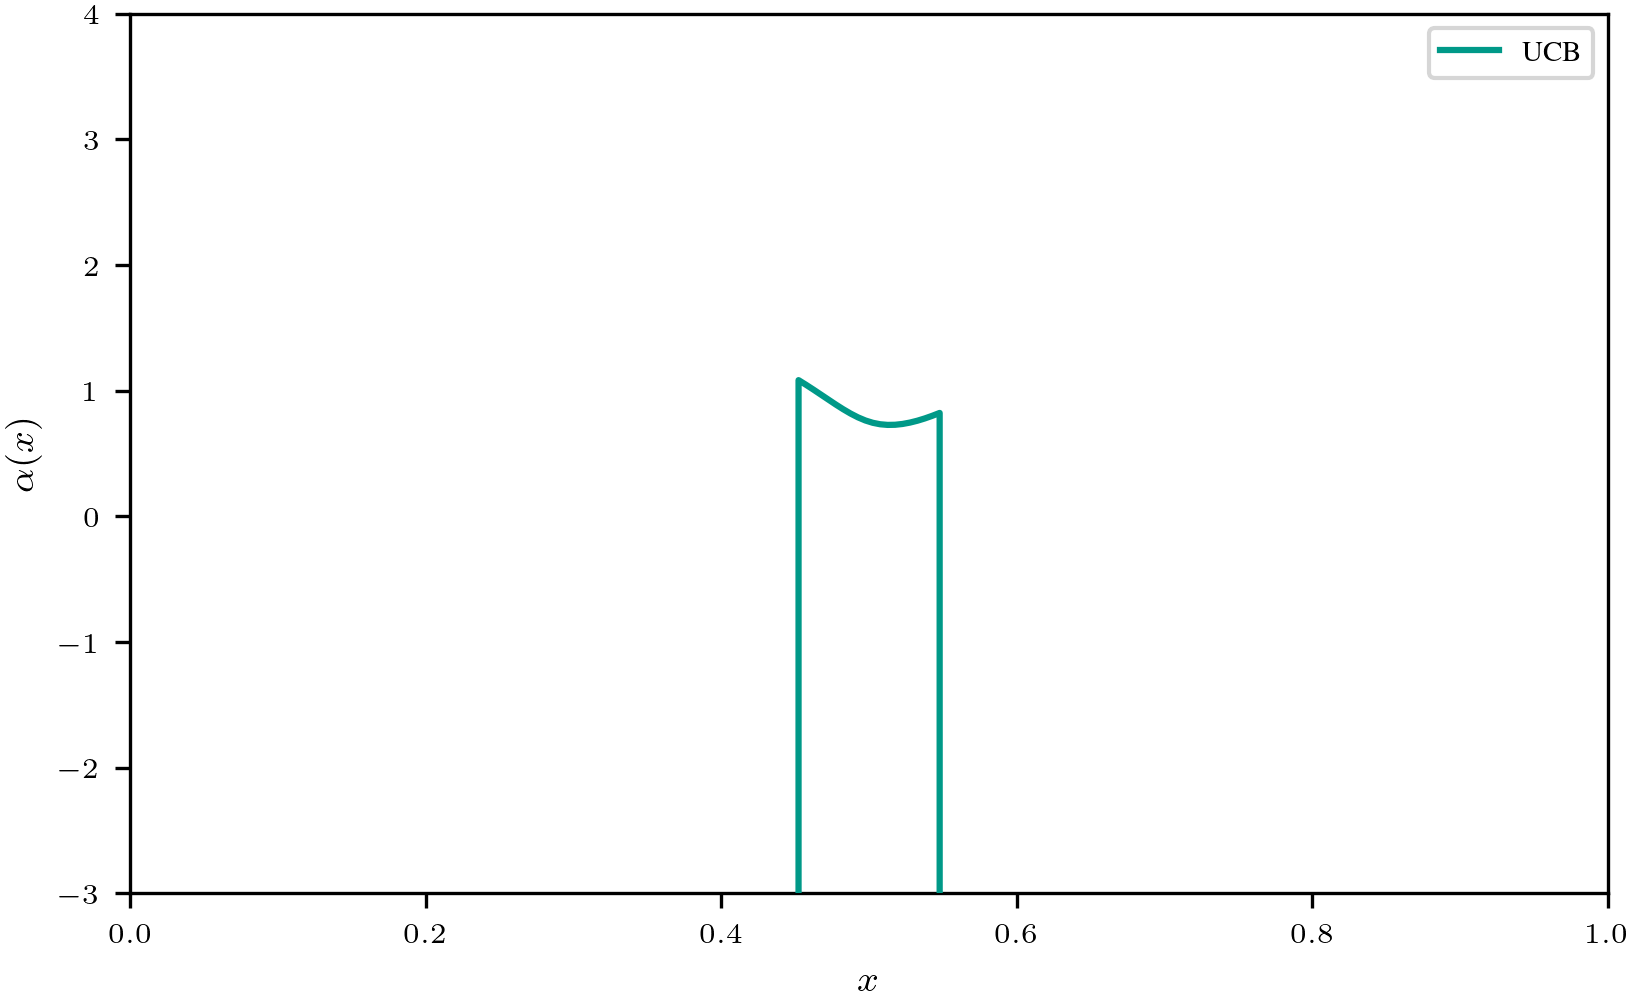

In [171]:
UCB = qUpperConfidenceBound(
    model=gp_model, beta=3
)

visible_range = torch.linspace(0, 1, 200).reshape(-1, 1, 1)
ucb_val = acqf(UCB, mid_point.reshape(-1, 1).double(), visible_range.double()).detach()
plt.plot(visible_range.flatten().numpy(), ucb_val.flatten().numpy(), label="UCB", zorder=99, color="#009988")

# plt.axvline(x=lower_bound, color='black', linestyle='--')
# plt.axvline(x=upper_bound, color='black', linestyle='--')

plt.xlim(0, 1)
plt.ylim(-3, 4)
plt.xlabel('$x$')
plt.ylabel(r'$\alpha(x)$')
plt.legend()

plt.savefig("step4.png")
plt.show()
plt.close()

In [99]:
y_post.numpy()[0].shape

(100,)

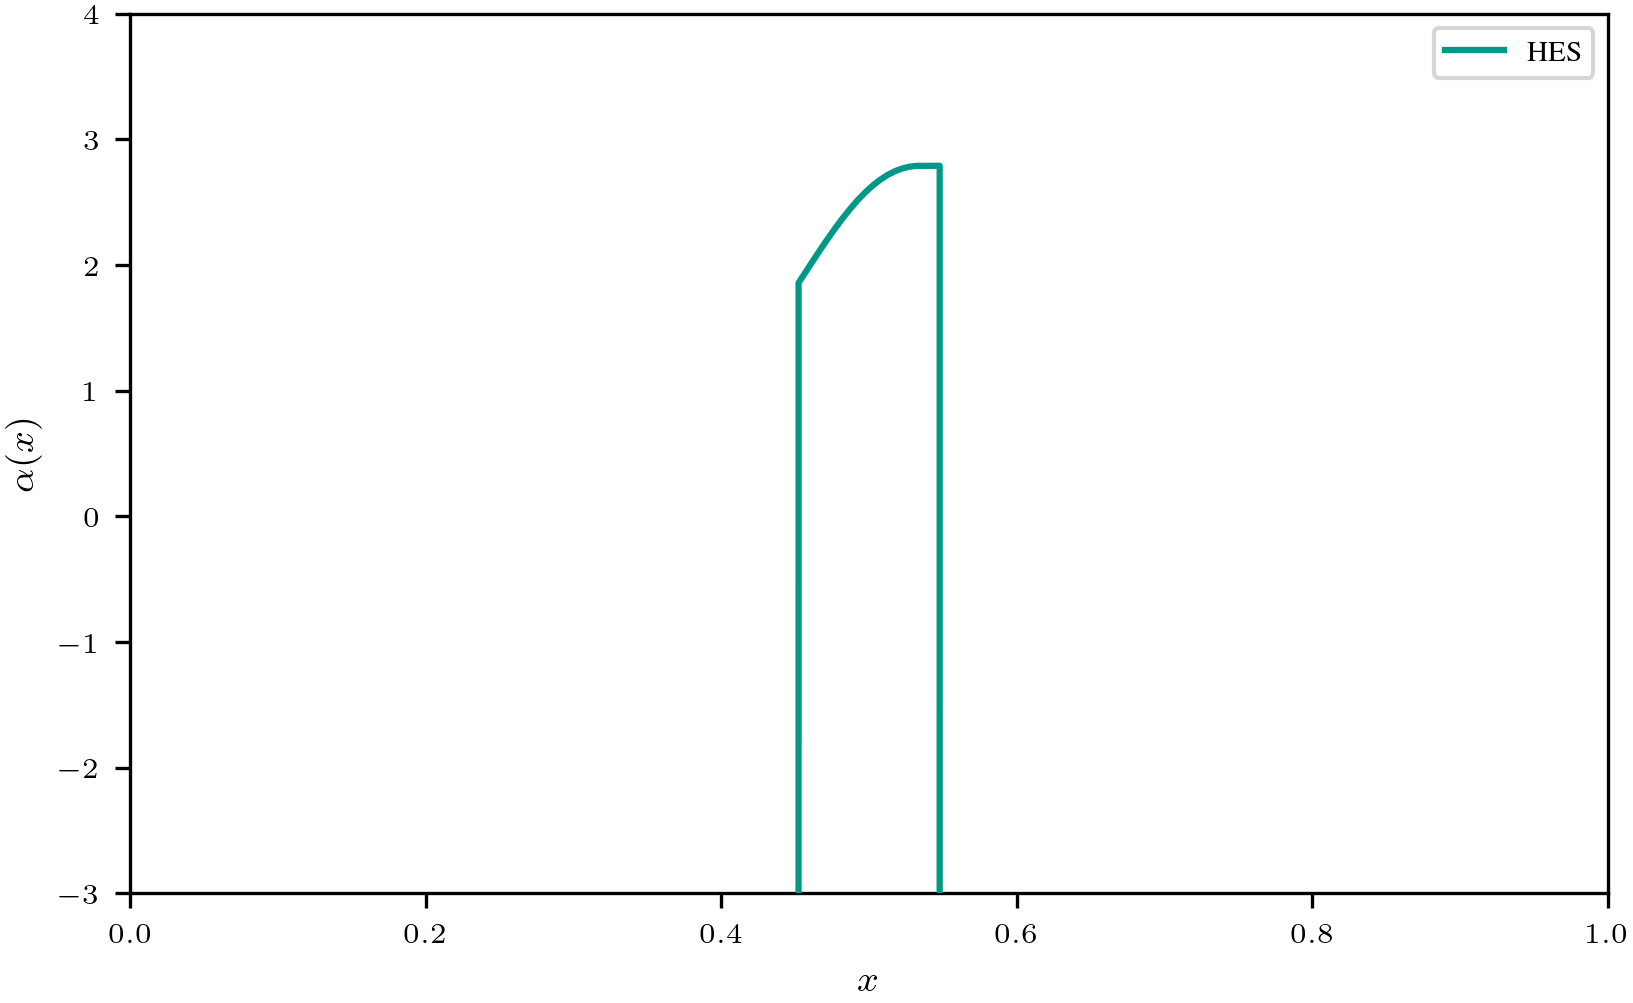

In [174]:
def HES(X):
    X = X.reshape(-1, 1)
    return f(X)[36].reshape(-1)
    
visible_range = torch.linspace(0, 1, 200).reshape(-1, 1, 1)
hes_val = acqf(HES, mid_point.reshape(-1, 1).double(), visible_range.double(), name="HES").detach()
plt.plot(visible_range.flatten().numpy(), hes_val.flatten().numpy(), label="HES", zorder=99, color="#009988")

# plt.axvline(x=lower_bound, color='black', linestyle='--')
# plt.axvline(x=upper_bound, color='black', linestyle='--')

plt.xlim(0, 1)
plt.ylim(-3, 4)
plt.xlabel('$x$')
plt.ylabel(r'$\alpha(x)$')
plt.legend()

plt.savefig("step5.png")
plt.show()
plt.close()

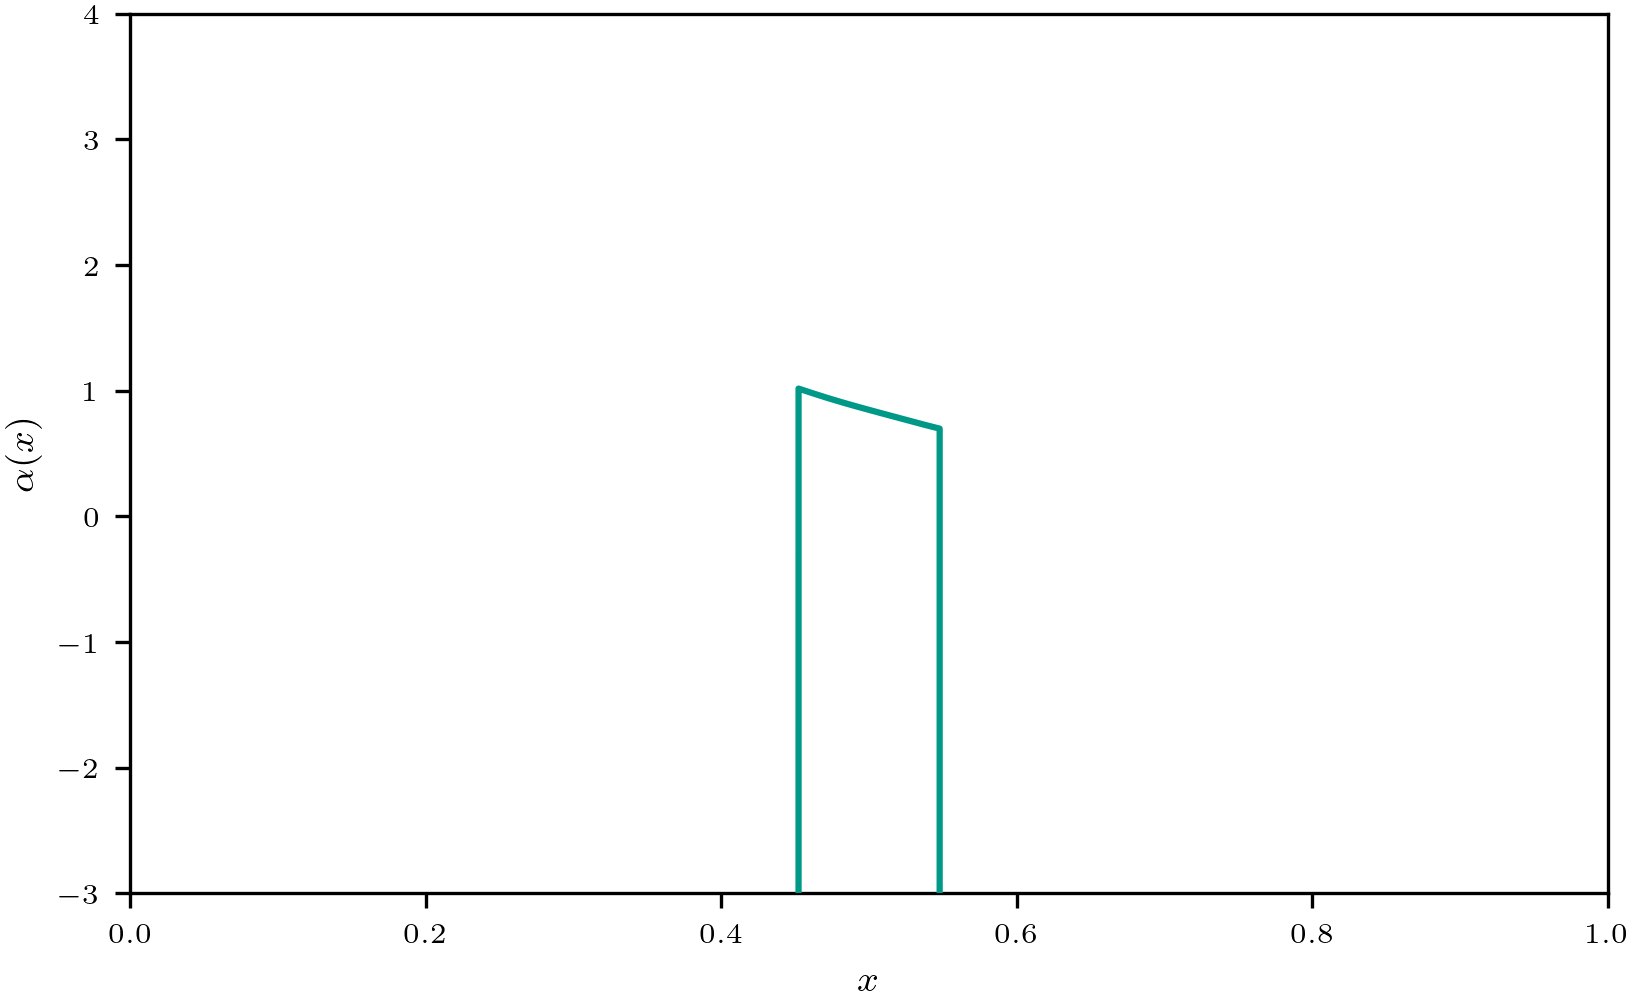

In [173]:
visible_range = torch.linspace(0, 1, 200).reshape(-1, 1, 1)
hes_val = acqf(HES, mid_point.reshape(-1, 1).double(), visible_range.double(), name="HES", lah_steps=1).detach()
plt.plot(visible_range.flatten().numpy(), hes_val.flatten().numpy(), label="HES", zorder=99, color="#009988")

# plt.axvline(x=lower_bound, color='black', linestyle='--')
# plt.axvline(x=upper_bound, color='black', linestyle='--')

plt.xlim(0, 1)
plt.ylim(-3, 4)
plt.xlabel('$x$')
plt.ylabel(r'$\alpha(x)$')
# plt.legend()

plt.savefig("step6.png")
plt.show()
plt.close()